<a href="https://colab.research.google.com/github/Talha1818/Machine-Learning-Python-Notebooks/blob/master/gpt2_document_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Annotation Folder/Final_Text_Dataset_08_May_2023.csv")
df['token'] = df['token'].astype(int)
df.head()

,page#,package_name,text,token,clean_text
0,1.0,612445_NJ_BURLINGTON,"HADDONEIELD - CITY ABSTRACT, L 1LBS 10OF1\nFAS...",15,haddoneield city abstract lbs fasbsned dwr hip...
1,2.0,612445_NJ_BURLINGTON,ACKNOWLEDGMENT OF NO SURVEY COVERAGE\nSTATE OF...,72,acknowledgment survey coverage state applicati...
2,3.0,612445_NJ_BURLINGTON,"City Abstract, LLC ALTA Buyer's Settlement Sta...",11,city abstract llc alta buyers settlement state...
3,4.0,612445_NJ_BURLINGTON,P Description\nTile - Notary Fee to City Abstr...,11,description tile notary fee city abstract titl...
4,5.0,612445_NJ_BURLINGTON,"City Abstract, LLC ALTA Seller's Settlement St...",13,city abstract llc alta sellers settlement stat...


In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
import re


# Define regex patterns
punct_pattern = r'[^\w\s]'
num_pattern = r'\d+'
special_pattern = r'[^A-Za-z0-9\s]'

# Define cleaning function
def clean_text(text):
    text = re.sub(r'\\n|\n', ' ', text)
    # remove links
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\x00|\\x00', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(punct_pattern, '', text)
    # Remove integers
    text = re.sub(num_pattern, '', text)
    # Remove special characters
    text = re.sub(special_pattern, '', text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    # Remove nextline
    text = re.sub(r'\n', ' ', text)
    # Remove words with length 1
    text = ' '.join(word for word in text.split() if len(word) > 2)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['clean_text'] = "[SOD] " + df['clean_text'] + " [EOD]"

df = df[df['clean_text'].notna()]
df = df[df['token'].notna()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df1 = df['token'].value_counts().to_frame().reset_index().rename(columns={'index':'token','token':'count'})
df_100 = df1[df1['count']>=100]['token'].tolist()
df_new = df[df['token'].isin(df_100)]
len(df_new['token'].unique())

123

In [ ]:
df = df_new.copy()
df.head()

,page#,package_name,text,token,clean_text
0,1.0,612445_NJ_BURLINGTON,"HADDONEIELD - CITY ABSTRACT, L 1LBS 10OF1\nFAS...",15,[SOD] haddoneield city abstract lbs fasbsned d...
1,2.0,612445_NJ_BURLINGTON,ACKNOWLEDGMENT OF NO SURVEY COVERAGE\nSTATE OF...,72,[SOD] acknowledgment survey coverage state app...
2,3.0,612445_NJ_BURLINGTON,"City Abstract, LLC ALTA Buyer's Settlement Sta...",11,[SOD] city abstract llc alta buyers settlement...
3,4.0,612445_NJ_BURLINGTON,P Description\nTile - Notary Fee to City Abstr...,11,[SOD] description tile notary fee city abstrac...
4,5.0,612445_NJ_BURLINGTON,"City Abstract, LLC ALTA Seller's Settlement St...",13,[SOD] city abstract llc alta sellers settlemen...


In [ ]:
df['token'].value_counts()[:5]

15    6865
14    5941
30    5172
28    4792
40    4702
Name: token, dtype: int64

In [ ]:
df.shape

(87570, 5)

In [ ]:
df = df[df['token'].isin(df['token'].value_counts()[:5].index.tolist())]

In [ ]:
df.shape

(27472, 5)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder object
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
df['token'] = label_encoder.fit_transform(df['token'])
df['token'].value_counts()

# Get mapping of label encoding values to original classes
label_encoding_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(label_encoding_mapping)

{0: 14, 1: 15, 2: 28, 3: 30, 4: 40}


In [ ]:
df = df[['clean_text', 'token']]
df.head(2)

,clean_text,token
0,[SOD] haddoneield city abstract lbs fasbsned d...,1
6,[SOD] form statement final loan terms closing ...,0


In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

<Axes: xlabel='token'>

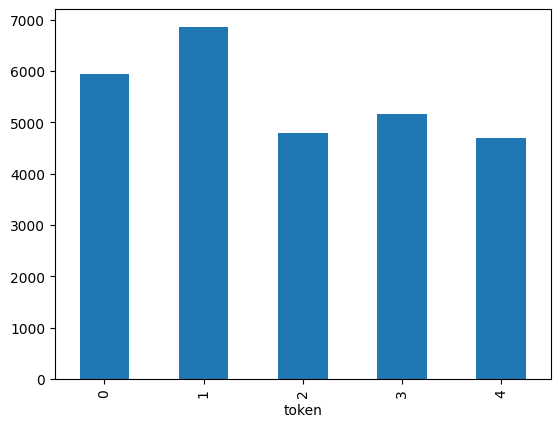

In [ ]:
df.groupby("token").size().plot.bar()

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
# labels = {
#     "business": 0,
#     "entertainment": 1,
#     "sport": 2,
#     "tech": 3,
#     "politics": 4
#          }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # self.labels = [labels[label] for label in df['category']]
        self.labels = [label for label in df['token']]

        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['clean_text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

21977 2747 2748


In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 1374/1374 [08:50<00:00,  2.59it/s]


Epochs: 1 | Train Loss:  0.015             | Train Accuracy:  0.926             | Val Loss:  0.011             | Val Accuracy:  0.953


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.959


In [ ]:
label_encoding_mapping.values()

dict_values([14, 15, 28, 30, 40])

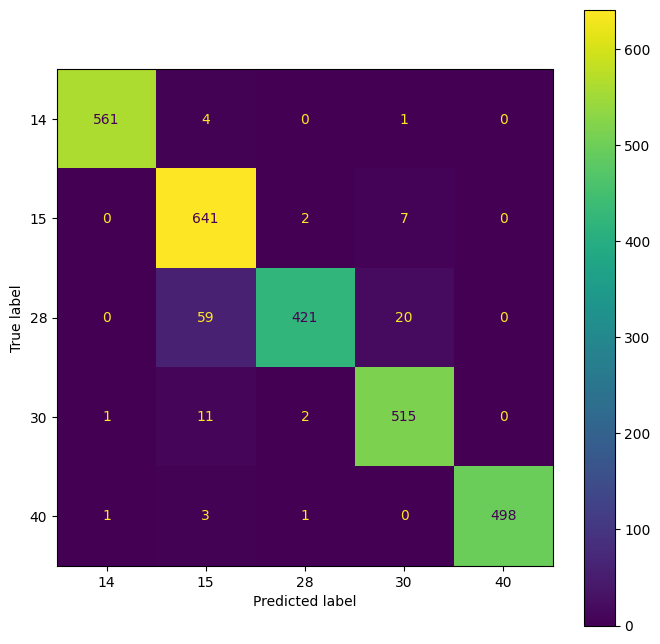

In [60]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
# cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(list(label_encoding_mapping.values()))), normalize='true')
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(list(label_encoding_mapping.values()))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_encoding_mapping.values()))
disp.plot(ax=ax)
# Save the figure
plt.savefig('confusion_matrix.png', bbox_inches='tight')

In [61]:
cm

array([[561,   4,   0,   1,   0],
       [  0, 641,   2,   7,   0],
       [  0,  59, 421,  20,   0],
       [  1,  11,   2, 515,   0],
       [  1,   3,   1,   0, 498]])

In [ ]:
# save trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/Annotation Folder/GPT2/gpt2-text-classifier-model.pt")

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("/content/drive/MyDrive/Annotation Folder/GPT2/gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=5, bias=True)
)

In [ ]:
example_text = """
[SOD] haddoneield city abstract lbs fasbsned dwr hip omgasssss nfm inc dba nfm lending winterson road suite linthicum tat maps billing xol [EOD]
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

[sod] haddoneield city abstract lbs fasbsned dwr hip omgasssss nfm inc dba nfm lending winterson road suite linthicum tat maps billing xol [eod]


In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[-3.0037,  7.8471, -2.7064, -4.2888, -5.6277]],
       grad_fn=<AddmmBackward0>)


In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [55]:
prob

tensor([1.9389e-05, 9.9995e-01, 2.6099e-05, 5.3634e-06, 1.4059e-06],
       grad_fn=<SelectBackward0>)

In [ ]:
label_encoding_mapping

{0: 14, 1: 15, 2: 28, 3: 30, 4: 40}

In [ ]:
print(output.argmax(dim=1).item())
pred_label = label_encoding_mapping[output.argmax(dim=1).item()]
print(pred_label)

1
15


In [ ]:
df['clean_text'][:10].values.tolist()[0]

'[SOD] haddoneield city abstract lbs fasbsned dwr hip omgasssss nfm inc dba nfm lending winterson road suite linthicum tat maps billing xol [EOD]'